In [1]:
import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [2]:
import torch
from astra.torch.models import ResNetClassifier,ResNet18_Weights
from astra.torch.data import load_cifar_10
import torch
import torch.nn as nn
from glob import glob
from os.path import expanduser, join, basename, dirname
import xarray as xr
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
from torch.utils.data import TensorDataset, DataLoader
from astra.torch.models import ResNetClassifier,ResNet18_Weights
from astra.torch.utils import train_fn

import torchvision.models as models
from astra.torch.metrics import accuracy_score, f1_score, precision_score, recall_score,classification_report

/home/rishabh.mondal/ASTRA/astra/torch/data.py:12: UserWarning: TORCH_HOME not set, setting it to /home/rishabh.mondal/.cache/torch
  warnings.warn(f"TORCH_HOME not set, setting it to {os.environ['TORCH_HOME']}")


In [3]:
dataset = load_cifar_10()
dataset

Files already downloaded and verified
Files already downloaded and verified



CIFAR-10 Dataset
length of dataset: 60000
shape of images: torch.Size([3, 32, 32])
len of classes: 10
classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
dtype of images: torch.float32
dtype of labels: torch.int64
range of image values: min=0.0, max=1.0
            

#### Make dataset for one vs rest classification

In [4]:
n_train=10000
n_pool=40000
n_test=20000
y=dataset.targets
x=dataset.data
classes=dataset.classes
class_1_idx=classes.index('frog')
class_1_mask=y==class_1_idx
y=class_1_mask.byte()
print(y)
print(len(y))
idx=torch.randperm(len(y))
train_data=x[idx[:n_train]]
train_targets=y[idx[:n_train]]

# pool_data=x[idx[n_train:-n_test]]
# pool_targets=y[idx[n_train:-n_test]]

test_data=x[idx[-n_test:]]
test_targets=y[idx[-n_test:]]

pool_data=x[idx[:n_pool]]
pool_targets=y[idx[:n_pool]]

print(train_data.shape)
print(train_targets.shape)
print(pool_data.shape)
print(pool_targets.shape)
print(test_data.shape)
print(test_targets.shape)


tensor([1, 0, 0,  ..., 0, 0, 0], dtype=torch.uint8)
60000
torch.Size([10000, 3, 32, 32])
torch.Size([10000])
torch.Size([40000, 3, 32, 32])
torch.Size([40000])
torch.Size([20000, 3, 32, 32])
torch.Size([20000])


In [5]:
# def remove_patches(images):
#     patched_images = images.clone()
#     for i in range(images.size(0)):
#         # Randomly choose the top-left corner of the patch
#         row_start = torch.randint(0, 25, (1,))
#         col_start = torch.randint(0, 25, (1,))
        
#         # Remove the 8x8 patch
#         patched_images[i, :, row_start:row_start+8, col_start:col_start+8] = 0

#     return patched_images
# train_indices = idx[:n_pool]
# print(len(train_indices))
# train_data_patch = remove_patches(pool_data)
# print(train_data_patch.shape)
# import matplotlib.pyplot as plt
# import torchvision.transforms.functional as F

# # Function to display images
# def display_images(images, targets, classes, num_images=5):
#     plt.figure(figsize=(15, 3))
#     for i in range(num_images):
#         plt.subplot(1, num_images, i + 1)
#         image = F.to_pil_image(images[i])
#         plt.imshow(image)
#         plt.title(f"Target: {classes[targets[i].item()]}")
#         plt.axis('off')
#     plt.show()

# # Display five images from the modified train dataset
# display_images(train_data_patch, train_targets, dataset.classes, num_images=5)
# display_images(fill_patches_with_white, train_targets, dataset.classes, num_images=5)

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(0)




In [7]:
import torchvision.transforms as transforms
aug = transforms.Compose([

    transforms.RandomGrayscale(p=0.2),
    transforms.ColorJitter(0.8*0.1, 0.8*0.1, 0.8*0.1, 0.2*0.1),
    transforms.GaussianBlur(kernel_size=23, sigma=(0.1, 2.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5)
])

In [8]:
augmentaed_images=aug(pool_data)
print(augmentaed_images.shape)
augmentaed_images1=aug(pool_data)
dataset1 = TensorDataset(augmentaed_images,augmentaed_images1)

torch.Size([40000, 3, 32, 32])


In [9]:
from torch.utils.data import DataLoader, random_split, TensorDataset

train_ratio = 0.8
dataset_size = len(dataset1)
train_size = int(train_ratio * dataset_size)
val_size = dataset_size - train_size

# Split the dataset
train_dataset, val_dataset = random_split(dataset1, [train_size, val_size])

# You can then create DataLoader instances for training and validation
pretrain_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
preval_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)


### Pretrain Task SimCLR

In [10]:
import torch 
import torch.nn as nn
from torchvision.models import resnet18

class SimCLR(nn.Module):
    def __init__(self, out_dim):
        super(SimCLR, self).__init__()
        resnet = resnet18(weights=None)
        res_out_dim = resnet.fc.in_features
        #resnet encoder
        self.f = nn.Sequential(*list(resnet.children())[:-1])
        #non linear projection head
        self.g = nn.Sequential(nn.Linear(res_out_dim, res_out_dim), nn.ReLU(), nn.Linear(res_out_dim, out_dim))

    def forward(self, xi, xj):
        x = torch.cat([xi, xj], dim=0)
        h = self.f(x)
        z = self.g(h.squeeze())
        return h, z

    def get_hidden(self, x):
        h = self.f(x)
        return h.squeeze()

        



In [11]:
from torchsummary import summary
models = SimCLR(128).to('cuda')
# Assuming 'model' is your SimCLR model
summary(models, input_size=[(3, 32, 32), (3, 32, 32)])


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [12]:
device = 'cuda' if torch.cuda.is_available else 'cpu'

### Hyperparameters setting
epochs = 100
batch_size = 64
T = 0.5
proj_dim = 512
num_worker = 8
valid_size = 0.2
strength = 1.0
trainloss = []
valloss = []

In [13]:
model = SimCLR(out_dim=proj_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), 1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(pretrain_loader), eta_min=0, last_epoch=-1)
val_loss = 1e9


In [14]:
import torch.nn.functional as F


In [15]:
def NTXent(z, N):
    # z = F.normalize(z, dim=1)
    mask = torch.eye(N*2).to(device).bool()
    tmp = torch.mm(z, z.T).masked_fill(mask, float('-inf'))
    loss_matrix = - F.log_softmax(tmp / T, dim=1) 
    loss = sum(torch.diag(loss_matrix[:N, N:]))+sum(torch.diag(loss_matrix[N:, :N]))
    loss /= 2 * N
    return loss

In [16]:
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for x1, x2 in pretrain_loader:
        x1, x2 = x1.to(device), x2.to(device)
        h, z = model(x1, x2)
        loss = NTXent(z, x1.size(0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        scheduler.step()
    epoch_loss /= len(pretrain_loader)
    trainloss.append(epoch_loss)
    # print(f'Epoch {epoch+1}/{epochs}, train loss: {epoch_loss:.4f}')
    if epoch_loss < val_loss:
        val_loss = epoch_loss
        torch.save(model.state_dict(), '/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/Saved_model/model.pt')
    model.eval()
    epoch_loss = 0
    for x1, x2 in preval_loader:
        x1, x2 = x1.to(device), x2.to(device)
        h, z = model(x1, x2)
        loss = NTXent(z, x1.size(0))
        epoch_loss += loss.item()
    epoch_loss /= len(preval_loader)
    valloss.append(epoch_loss)
    # print(f'Epoch {epoch+1}/{epochs}, val loss: {epoch_loss:.4f}')    
    if (epoch+1) % 10 == 0:
        print(f'Train loss after {epoch+1} epochs: {trainloss[-1]:.4f}')
        print(f'Val loss after {epoch+1} epochs: {valloss[-1]:.4f}')


Train loss after 10 epochs: 0.0133
Val loss after 10 epochs: 0.0268
Train loss after 20 epochs: 0.0088
Val loss after 20 epochs: 0.0342
Train loss after 30 epochs: 0.0081
Val loss after 30 epochs: 0.0211
Train loss after 40 epochs: 0.0076
Val loss after 40 epochs: 0.0438
Train loss after 50 epochs: 0.0157
Val loss after 50 epochs: 0.1218
Train loss after 60 epochs: 0.0093
Val loss after 60 epochs: 0.1340
Train loss after 70 epochs: 0.0078
Val loss after 70 epochs: 0.0512
Train loss after 80 epochs: 0.0053
Val loss after 80 epochs: 0.0153
Train loss after 90 epochs: 0.0041
Val loss after 90 epochs: 0.0115
Train loss after 100 epochs: 0.0078
Val loss after 100 epochs: 0.0150


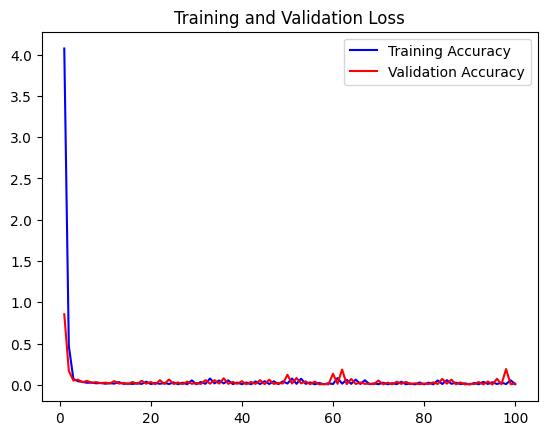

In [17]:
eps = range(1, len(trainloss) + 1)
plt.plot(eps, trainloss, 'b', label='Training Accuracy')
plt.plot(eps, valloss, 'r', label='Validation Accuracy')
plt.title('Training and Validation Loss')
plt.legend()

### Downstream Task : Classification 1 vs rest

In [18]:
class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        proj_dim = 512
        hidden_dim = 256
        self.encoder = SimCLR(out_dim=proj_dim)
        path=torch.load('/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/Saved_model/model.pt')
        # print("Load checkpoint trained for %d epochs. Loss is %f." %(path["epoch"], path["loss"]))
        self.encoder.load_state_dict(path)
        self.fc=nn.Sequential(nn.Linear(proj_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, 2))
    def forward(self, x):
        out=self.encoder.get_hidden(x)
        out=self.fc(out)
        return out


In [19]:
train_dataset=TensorDataset(train_data,train_targets)
train_loader=DataLoader(train_dataset, batch_size=256, shuffle=True)
test_dataset=TensorDataset(test_data,test_targets)
test_loader=DataLoader(test_dataset, batch_size=256, shuffle=False)

In [20]:
finetune=True
proj_dim = 512
hidden_dim = 256
target_acc=0.0
model = CustomModel().to(device)
if finetune:
    for param in model.encoder.parameters():
        param.requires_grad = False
optimizer=torch.optim.Adam(list(model.encoder.f.parameters())+list(model.fc.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss()
train_acc=[]
val_acc=[]
for epoch in range(100):
    t_total = 0
    t_correct = 0
    train_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        h = model.encoder.get_hidden(x)
        logits = model.fc(h)

        pred = torch.argmax(logits, dim=1)
        t_total += y.shape[0]
        t_correct += (pred == y).sum().item()

        optimizer.zero_grad()
        loss = F.cross_entropy(logits, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_acc.append(100.0 * t_correct / t_total)
    print(f"Epoch {epoch+1}/{epochs}, Train Accuracy: {train_acc[-1]:.2f}%, Train Loss: {train_loss:.4f}")
    correct = 0    
    total = 0
    model.eval()
    with torch.no_grad():
        for test_x, test_y in test_loader:
            test_x, test_y = test_x.to(device), test_y.to(device) 
            h = model.encoder.get_hidden(test_x)
            logits = model.fc(h)
              
            pred = torch.argmax(logits, dim=1)
            total += test_y.shape[0]
            correct += (pred == test_y).sum().item()
        valid_acc = 100.0 * correct / total
        val_acc.append(valid_acc)
        print(f"Epoch {epoch+1}/{epochs}, Validation Accuracy: {valid_acc:.2f}%")

    if (valid_acc>target_acc):
        target_acc=valid_acc
        torch.save({"model": model.state_dict(), "epoch": epoch, "loss": loss}, "/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/Saved_model/fullmodel_trial.pt")



Epoch 1/100, Train Accuracy: 89.36%, Train Loss: 11.7233
Epoch 1/100, Validation Accuracy: 90.13%
Epoch 2/100, Train Accuracy: 90.17%, Train Loss: 10.0194
Epoch 2/100, Validation Accuracy: 90.36%
Epoch 3/100, Train Accuracy: 90.33%, Train Loss: 9.7790
Epoch 3/100, Validation Accuracy: 90.34%
Epoch 4/100, Train Accuracy: 90.36%, Train Loss: 9.6302
Epoch 4/100, Validation Accuracy: 90.44%
Epoch 5/100, Train Accuracy: 90.16%, Train Loss: 9.6494
Epoch 5/100, Validation Accuracy: 90.28%
Epoch 6/100, Train Accuracy: 90.40%, Train Loss: 9.5823
Epoch 6/100, Validation Accuracy: 90.44%
Epoch 7/100, Train Accuracy: 90.57%, Train Loss: 9.7200
Epoch 7/100, Validation Accuracy: 90.46%
Epoch 8/100, Train Accuracy: 90.49%, Train Loss: 9.3444
Epoch 8/100, Validation Accuracy: 90.36%
Epoch 9/100, Train Accuracy: 90.67%, Train Loss: 9.3254
Epoch 9/100, Validation Accuracy: 90.50%
Epoch 10/100, Train Accuracy: 90.80%, Train Loss: 9.1564
Epoch 10/100, Validation Accuracy: 90.39%
Epoch 11/100, Train Accura

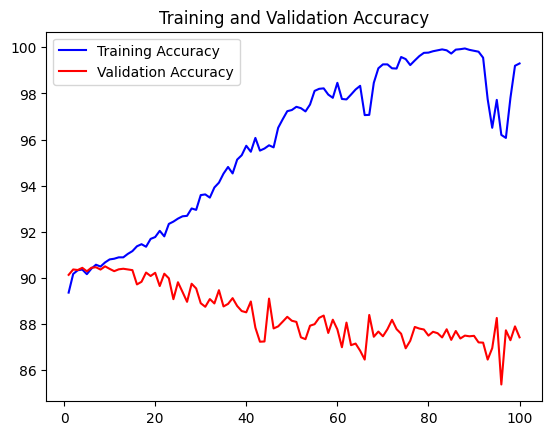

In [21]:
eps = range(1, len(train_acc) + 1)
plt.plot(eps, train_acc, 'b', label='Training Accuracy')
plt.plot(eps, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend();

In [22]:
import sklearn
def evaluate(test_loader, model, device):
    correct = 0    
    total = 0
    confusion_matrix = torch.zeros(2,2)
    model.eval()
    
    #Prints confusion matrix
    with torch.no_grad():
        for test_x, test_y in test_loader:
            test_x, test_y = test_x.to(device), test_y.to(device) 
            h = model.encoder.get_hidden(test_x)
            logits = model.fc(h)
              
            pred = torch.argmax(logits, dim=1)
            total += test_y.shape[0]
            correct += (pred == test_y).sum().item()
            for l, p in zip(test_y.view(-1), pred.view(-1)):
                confusion_matrix[l.long(), p.long()] += 1
                
    total_acc = 100.0 * correct / total
    print(confusion_matrix)
    #calculate f1 score
    
    print(f"Test Accuracy: {total_acc:.2f}%")
    # print(f"F1 Score: {f1_score:.2f}%")
    return total_acc

In [23]:
acc = evaluate(test_loader, model, device)


tensor([[16964.,  1062.],
        [ 1454.,   520.]])
Test Accuracy: 87.42%


In [24]:
import numpy as np

confusion_matrix = np.array([[17209., 744.], [1661., 386.]])

true_positives = confusion_matrix[1, 1]
false_positives = confusion_matrix[0, 1]
false_negatives = confusion_matrix[1, 0]

precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)

f1_score = 2 * (precision * recall) / (precision + recall)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1_score:.2f}")


Precision: 0.34
Recall: 0.19
F1 Score: 0.24
